In [ ]:
from __future__ import unicode_literals

In [ ]:
from sklearn.model_selection import train_test_split
import unittest
import numpy as np
from keras_performer import performer as tfr
import nltk

from os import listdir
from os.path import isfile, isdir, join
from nltk.tokenize import wordpunct_tokenize

nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
'''
def solve_cudnn_error():
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
            
solve_cudnn_error()
'''

'\ndef solve_cudnn_error():\n    import tensorflow as tf\n    gpus = tf.config.experimental.list_physical_devices(\'GPU\')\n    if gpus:\n        try:\n            # Currently, memory growth needs to be the same across GPUs\n            for gpu in gpus:\n                tf.config.experimental.set_memory_growth(gpu, True)\n            logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n        except RuntimeError as e:\n            # Memory growth must be set before GPUs have been initialized\n            print(e)\n            \nsolve_cudnn_error()\n'

In [ ]:
import csv
def readCSV(file_name):
  errlist=[]
  LBlist=[]
  with open(file_name, newline='') as csvfile:

# read CSV file contant，make each row to a dictionary

    rows = csv.DictReader(csvfile)
    for row in rows: 
      RL=list(row.values())

      RL = list(map(int, RL))
      errs=RL[1:37]
      LB=RL[37:]
      errlist.append(errs)
      LBlist.append(LB)
  return errlist,LBlist


In [ ]:
def find_first_sublist(seq, sublist, start=0):
    length = len(sublist)
    for index in range(start, len(seq)):
        if seq[index:index+length] == sublist:
            return index, index+length

In [ ]:
def replace_sublist(seq, sublist, replacement):
    length = len(replacement)
    index = 0
    for start, end in iter(lambda: find_first_sublist(seq, sublist, index), None):
        seq[start:end] = replacement
        index = start + length

In [ ]:
def replaceTAGS(x):
    replace_sublist(x, ['<', 'BOC', '>'], ["<BOC>"])
    replace_sublist(x, ['<', 'EOC', '>'], ["<EOC>"])
    replace_sublist(x, ['<', 'BOTM', '>'], ["<BOTM>"])
    replace_sublist(x, ['<', 'BOT', '>'], ["<BOT>"])
    replace_sublist(x, ['<', 'EOT', '>'], ["<EOT>"])
    replace_sublist(x, ['<', 'BOM', '>'], ["<BOM>"])
    replace_sublist(x, ['<', 'EOM', '>'], ["<EOM>"])
    replace_sublist(x, ['<', 'EOTM', '>'], ["<EOTM>"])
    replace_sublist(x, ['<', 'CR', '>'], ["<CR>"])
    return x

In [ ]:
def parseSentence(x):	
	tokenizer = RegexpTokenizer(r"[\w']+|[].,:!?;=+-\\*/@#$%^&_(){}~|\"[]")
	tokens=[]
	state="START"
	chrs=""
	for i in range(len(x)):
		#print(ord(x[i]))
		if (ord(x[i])>255):
			inp="U"
		else:
			inp="E"
	
		if state=="START":
			if inp=="E":
				state="ASCII"
				chrs=x[i]
			else:
				state="UNICODE"
				tokens.append(x[i])
			
		elif state=="ASCII":
			if inp=="E":
				chrs += x[i]
			else:#U
				state="UNICODE"
				tokens += tokenizer.tokenize(chrs) #wordpunct_tokenize(chrs)  #nltk.word_tokenize(chrs)
				chrs=""
				tokens.append(x[i])
	
		elif state=="UNICODE":
			if inp=="E":
				state="ASCII"
				chrs=x[i]
			else:
				state="UNICODE"
				tokens.append(x[i])
	if len(chrs)>0:
		tokens += tokenizer.tokenize(chrs) #wordpunct_tokenize(chrs)  # nltk.word_tokenize(chrs) 
	return tokens

In [ ]:
def readcode(fname):
    with open(fname) as f:
        data = f.read()
        return data

In [ ]:
from matplotlib import pyplot as plt
def plotTrainingLoss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
class TestTranslate(unittest.TestCase):
 
    @staticmethod
    def _build_token_dict(token_list):
        token_dict = {
            '<PAD>': 0,
            '<START>': 1,
            '<END>': 2,
            '<BOC>': 3,
            '<EOC>': 4,
            '<BOTM>': 5,
            '<BOT>': 6,
            '<EOT>': 7,
            '<BOM>': 8,
            '<EOM>': 9,
            '<EOTM>': 10,
            '<CR>': 11,
        }
        for tokens in token_list:
            for token in tokens:
                if token not in token_dict:
                    token_dict[token] = len(token_dict)
        return token_dict
 
    def test_translate(self):
        print("i am here: " )
        max_javaline_length=150  #Max number of lines 
        source_tokens = []
        target_errors=[]
        target_LB=[]
        #source_file=[]
        
        Input_Path = "/content/drive/MyDrive/AI_JAVA_ANNOTATION_PROJ_2021/論文+程式/乙班_Performer/Final Edition include model /Trianing/InputTxt"
        Location_Output_Path = "/content/drive/MyDrive/AI_JAVA_ANNOTATION_PROJ_2021/論文+程式/乙班_Performer/Final Edition include model /Trianing/InputCSV"
        '''
        Input_Path = "Performer/Perfomer_local/Trianing/InputTxt"
        Location_Output_Path = "Performer/Perfomer_local/Trianing/InputCSV"
        '''
 
        InputFiles = sorted(listdir(Input_Path))
        OutputFiles = sorted(listdir(Location_Output_Path))
        #max_files =10
        for f in InputFiles:
          fullpath = join(Input_Path,f)
          #source_file=fullpath
          if isfile(fullpath):
            source_tokens.append(parseSentence(readcode(fullpath)))
            #if len(source_tokens)>max_files: break
        for f in OutputFiles:
          fullpath = join(Location_Output_Path,f)
          #source_file=fullpath
          if isfile(fullpath):
            err,lb = readCSV(fullpath)
            target_errors.append(err)
            target_LB.append(lb)
            #if len(source_tokens)>max_files: break
        dd=np.asarray(target_errors)
        target_errors=target_errors[0]  
        target_LB=target_LB[0]     

        source_tokens2 = []
        target_errors2= []
        target_LB2=[]

        THRESHOLD_FILE_LEN = 64000000
 
        for i in range(len(source_tokens)): 
          #print (i)
          src = source_tokens[i]
          err = target_errors[i]   
          lb = target_LB[i]                   
          if (len(src)<=THRESHOLD_FILE_LEN):
            source_tokens2.append(src)
            target_errors2.append(err)
            target_LB2.append(lb) 
        source_tokens = source_tokens2
        target_errors= target_errors2        
        target_LB= target_LB2        

                    
 
        # Generate dictionaries
        source_token_dict = self._build_token_dict(source_tokens)
        
 
        # Add special tokens
        encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
        
        #output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens]
 
        # Padding
        self.sl = max(map(len, encode_tokens))
        
        source_max_len = self.sl
        
 
        encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
        
        
 
        encode_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encode_tokens]
       
        
        #print("encode_input:", encode_input)
        
        #print("len(source_token_dict):", len(source_token_dict))
        
        
        #decode_output_one_hot_encoded = to_categorical(decode_output)
        #print("one-hot-decode_output:", decode_output_one_hot_encoded)
        #decode_output =  list(decode_output_one_hot_encoded)
        token_num =len(source_token_dict)
        print(type(token_num))
        #Build & fit model
        #Set model para    
        model = tfr.get_model(
            max_input_len= (source_max_len),
            max_javaline_length=max_javaline_length,
            errNum=36,
            lbNum=len(target_LB[0]),
            token_num=len(source_token_dict),
            embed_dim=32, #32,
            encoder_num=4, #2 max = 6
            head_num=4,#4
            hidden_dim=64, #128
            dropout_rate=0.05 #0.05
        )
        #'LNout0'
        
        losses = {    
            "error_feed_forward_output1": "binary_crossentropy"}
            #"error_feed_forward_output2": "categorical_crossentropy",            
        
        
        lossWeights = {"error_feed_forward_output1": 1.0  }#"error_feed_forward_output2": 1.0}
        for i in range(len(target_LB[0])):  #列出 len(target_LB[0]) 組網路層
          name = "LNout"+str(i)
          losses[name] = "categorical_crossentropy"
          lossWeights[name] = 1 #error_feed_forward_output2[] weight

        
        model.compile(optimizer=Adam(learning_rate=0.001), loss=losses, loss_weights=lossWeights)
        
    
        
        
 
        #x=[np.array(encode_input * 1)]
        #y=[np.array(target_errors * 1),np.array(target_LB * 1)]
       
        #print("x.shape", np.asarray(x).shape)  #x.shape (2, 2048, 9)
        
        ####  Split the data set into train and test_model
        x=np.array(encode_input)
        y=list(zip(np.array(target_errors), np.array(target_LB)))


        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

        y_train = list(zip(*y_train))  
        y_train[0] = np.array(y_train[0])
        y_train[1] = np.array(y_train[1])

        y_train[1] = to_categorical(y_train[1], num_classes=max_javaline_length) #將類別向量轉換為二進制矩陣
        #y_train = list(zip(y_train[0], y_train[1]))

        y_train[1] = np.split(y_train[1], indices_or_sections=len(target_LB[0]), axis=1)
        y_train[1] = [  np.squeeze(elm, axis=1) for elm in y_train[1] ]
        
        y_test = list(zip(*y_test))
        y_test[0] = np.array(y_test[0])
        y_test[1] = np.array(y_test[1])
        y_test[1] = to_categorical(y_test[1], num_classes=max_javaline_length) 
        #y_test = list(zip(y_test[0], y_test[1])) 
        y_test[1] = np.split(y_test[1], indices_or_sections=len(target_LB[0]), axis=1) 
        y_test[1] = [  np.squeeze(elm, axis=1) for elm in y_test[1] ] 
        saveTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/train_models/x_train_500.npy", x_train)
        saveTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/test_models/x_test_500.npy", x_test)
        saveTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/train_models/y_train0_500.npy", y_train[0])#target
        saveTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/train_models/y_train1_500.npy", y_train[1])#lb
        saveTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/test_models/y_test0_500.npy", y_test[0])
        saveTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/test_models/y_test1_500.npy", y_test[1])
    
        ####
        #if you only need to train model don't use this
        
        history = model.fit(
            x=x_train,
            y= [y_train[0]] + y_train[1],
            epochs=1, #100 200 500
            batch_size=32,
        )
        plotTrainingLoss(history)
        model.save("/content/drive/MyDrive/Final_Edition_include_model/models/test_model1.h5")
        saveDictionary(source_token_dict, '/content/drive/MyDrive/Final_Edition_include_model/models/source_token_dict.pickle')
        
        model, source_token_dict = load("/content/drive/MyDrive/Final_Edition_include_model/models/test_model1.h5")

        # Predict
        
        x_train_loaded = loadTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/train_models/x_train_500.npy") 
        y_train_loaded_0 =   loadTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/train_models/y_train0_500.npy")
        y_train_loaded_1 =   loadTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/train_models/y_train1_500.npy") 

        x_test_loaded =  loadTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/test_models/x_test_500.npy") 
        y_test_loaded_0 =   loadTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/test_models/y_test0_500.npy")
        y_test_loaded_1 =   loadTestTrainData("/content/drive/MyDrive/Final_Edition_include_model/test_models/y_test1_500.npy") 
        
        out1, out2 = tfr.decode(
            model,
            #encode_input,
            x_test_loaded,max_len=source_max_len
        )
        print("out1: ", out1)
        #print("target_errors: ",target_errors) 
        print("target_errors: ", y_test_loaded_0)        
        print("out2: ", out2)
        #print("target_LB: ", target_LB)
        print("target_LB: ", y_test_loaded_1)
        
        #model.summary()
        train_loss = model.evaluate(x_train_loaded, [y_train_loaded_0] + list(y_train_loaded_1) )
        test_loss = model.evaluate(x_test_loaded, [y_test_loaded_0] + list(y_test_loaded_1) )
        print("test_loss",test_loss)
        
    def getsource_max_lan(self):
        return self.sl

In [ ]:
def saveDictionary(dt, file):
        import pickle
        a_file = open(file, "wb")
        pickle.dump(dt, a_file)
        a_file.close()

In [ ]:
def loadDictionary(file):
        import pickle
        a_file = open(file, "rb")
        dt = pickle.load(a_file)
        return dt

In [ ]:
def saveTestTrainData(filename, data): # e.g., 'test.npy'
    with open(filename, 'wb') as f:
        np.save(f, data)

In [ ]:
def loadTestTrainData(filename): # e.g., 'test.npy'    
    with open(filename, 'rb') as f:
        a = np.load(f)
        return a

In [ ]:
def load(model_name):
        import sys
        sys.path.append('/content/drive/MyDrive/Final_Edition_include_model')
        #sys.path.append('/content/drive/MyDrive/Final_Edition_include_model/keras_position_wise_feed_forward')
        #sys.path.append('/content/drive/MyDrive/Final_Edition_include_model/tensorflow_fast_attention')
        #sys.path.append('/content/drive/MyDrive/Final_Edition_include_model/keras_performer')
        #sys.path.append('/content/drive/MyDrive/Final_Edition_include_model/keras_pos_embed')

        from keras_performer import performer
        from tensorflow import keras
        from keras_embed_sim import EmbeddingRet, EmbeddingSim
        from keras_pos_embd import TrigPosEmbedding
        from tensorflow_fast_attention.fast_attention import  Attention, SelfAttention
        from keras_position_wise_feed_forward.feed_forward import FeedForward  

        co = performer.get_custom_objects()

        model = keras.models.load_model(model_name, custom_objects= co)
        source_token_dict = loadDictionary('/content/drive/MyDrive/Final_Edition_include_model/models/source_token_dict.pickle')
       # t = loadDictionary(target_token_dict, 'target_token_dict.pickle')
       # t_inv = loadDictionary(target_token_dict_inv, 'target_token_dict_inv.pickle')
        return model, source_token_dict,

i am here: 
AAAA:  (1, 359, 36)
aaaa:  <class 'list'>
XXXX:  359
YYYY:  <class 'int'>
ZZZZ:  359
ZZZZ len(target_LB[0]):  84
XXXX2:  359
<class 'int'>
In get_model: encoder_input:  (None, 2919)
In get_model: encoder_embed:  (None, 2919, 32)
Start Warpping................................
OOOO: KerasTensor(type_spec=TensorSpec(shape=(None, 2919, 32), dtype=tf.float32, name=None), name='Encoder-Embedding/add_1:0', description="created by layer 'Encoder-Embedding'")
embed_dim: 32
head_num: 4
dropout_rate: 0.05
masked: False
query_input: XXXXXXX  (None, 2919, 32)
source_input: XXXXXXX  (None, 2919, 32)
Query: XXXXXXX  (None, 2919, 4, 8)
Key: XXXXXXX  (None, 2919, 4, 8)
Value: XXXXXXX  (None, 2919, 4, 8)
dim:  8
query:  Tensor("self_attention_161/query/einsum/Einsum:0", shape=(None, 2919, 4, 8), dtype=float32)
QS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 16)
KS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 16)
Start Warppi

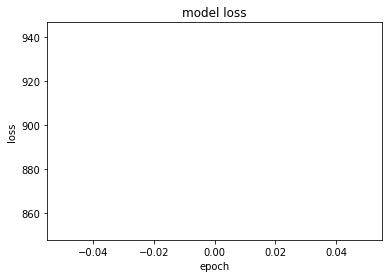

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


query_input: XXXXXXX  (None, 2919, 32)
source_input: XXXXXXX  (None, 2919, 32)
Query: XXXXXXX  (None, 2919, 4, 8)
Key: XXXXXXX  (None, 2919, 4, 8)
Value: XXXXXXX  (None, 2919, 4, 8)
QS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 8)
KS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 8)
query_input: XXXXXXX  (None, 2919, 32)
source_input: XXXXXXX  (None, 2919, 32)
Query: XXXXXXX  (None, 2919, 4, 8)
Key: XXXXXXX  (None, 2919, 4, 8)
Value: XXXXXXX  (None, 2919, 4, 8)
QS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 8)
KS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 8)
query_input: XXXXXXX  (None, 2919, 32)
source_input: XXXXXXX  (None, 2919, 32)
Query: XXXXXXX  (None, 2919, 4, 8)
Key: XXXXXXX  (None, 2919, 4, 8)
Value: XXXXXXX  (None, 2919, 4, 8)
QS OOOOOOOOOOOOO <class 'tensorflow.python.framework.ops.Tensor'> (2919, None, 4, 8)
KS OOOOOOOOOOOOO <class 'tens

In [ ]:
x=TestTranslate()
x.test_translate()

In [ ]:
#set model para
model_name = "test_model1.h5"
x_test_model = "x_test_500.npy" 
y_test_mdodel1 = "y_test0_500.npy" 
y_test_mdodel2 = "y_test1_500.npy" 

In [ ]:
#load model
def loadmodel(model_name, x_test_model, y_test_mdodel1, y_test_mdodel2):
    import numpy as np
    #load model and dic ps. dic is not use
    model, source_token_dict = load(model_name)
    #load
    x_test_loaded = loadTestTrainData("test_models/"+x_test_model) 
    y_test_loaded = [ loadTestTrainData("test_models/"+y_test_mdodel1), loadTestTrainData("test_models/"+y_test_mdodel2)] 
    out1, out2 = tfr.decode(model,x_test_loaded,max_len=x.getsource_max_lan()) 
    #==============show org result================
    ''' <-------dust switch
    print((y_test_loaded[0][1])) #Error_type #vs out1
    print((y_test_loaded[1][1])) #Line_Block #vs out2
    print((out1[1]))#prob upper then 0.5
    print((out2[1]))#prob upper then 0.5
    print(int(out2))#prob lb
    #'''
    #=============================================
    test_ep = np.around(out1)
    test_lb = np.around(out2)
    ans_ep = np.around(y_test_loaded[0])
    ans_lb = np.around(y_test_loaded[1])
    #==============show toint result==============
    #''' <-------dust switch
    print(test_ep[1])
    print(test_lb[1])
    print(ans_ep[1])
    print(ans_lb[1])
    #'''
    #=============================================
    return test_ep, ans_ep, test_lb, ans_lb

In [ ]:
def intersect(pre_errortype, ans_errortype):
    #print("inter :", pre_errortype)
    #print("inter: ", ans_errortype)
    #ans_errortype = float(ans_errortype)
    #ref = "https://www.796t.com/post/Mjc4am8=.html"
    inter = [pre_value for pre_value, ans_value in zip(pre_errortype, ans_errortype) if (pre_value == ans_value == 1)]
    inter_two = [pre_value for pre_value, ans_value in zip(pre_errortype, ans_errortype) if (pre_value == ans_value)]
    #print("sort inter: ", inter)
    return inter, inter_two

In [ ]:
#get new ans array contains only 1 in array 
def ans_typefilter(ans_errortype):
    #print("org ans type: ", ans_errortype)
    new_ans_errortype = [value for value in ans_errortype if value == 1]
    #print("new ans errortype: ", new_ans_errortype)
    return new_ans_errortype

In [ ]:
#get new pre array contains only 1 in array 
def pre_typefilter(pre_errortype):
    #print("org error type: ", pre_errortype)
    new_pre_errortype = [value for value in pre_errortype if value == 1]
    #print("new pre errortype: ", new_pre_errortype)
    return new_pre_errortype

In [ ]:
#calculate error type score
#Note:
    #Predict score:
        # score = inter of ans and pre divide by len of pre
    #Recall score:
        # score = inter of ans and pre divide by len of ans
    #Accuracy score:
        # score = inter_two of ans and pre divide by original len of pre
def errortype_score(pre_errortype, ans_errortype):
    #find pre length
    new_pre_errortype = pre_typefilter(pre_errortype) #make new array for score
    pre_length = len(new_pre_errortype) #get lenght from ans_type
    #find ans length
    new_ans_errortype = ans_typefilter(ans_errortype) #make new array for score
    ans_length = len(new_ans_errortype) #get lenght from ans_type
    #print("ans length: ", ans_length)
    inter, inter_two = intersect(pre_errortype, ans_errortype) #get intersection
    inter_length = len(inter)
    inter_two_length = len(inter_two)
    #print("inter_length: ", inter_length)
    #print("pre length: ", pre_length) 
    
    #calculate Predict score 
    if (inter_length == 0 and pre_length == 0):
        pre_score = 1
    elif (pre_length == 0):
        pre_score = 0
    else:
        pre_score = inter_length/pre_length 
    #print("predict score: ", pre_score) #show pre score
    
    #calculate Recall score
    if (inter_length == 0 and ans_length == 0):
        rec_score = 1
    elif (ans_length == 0):
        rec_score = 0
    else:
        rec_score = inter_length/ans_length
    #print("recall score: ", rec_score) #show ans score
    
    #calculate Accuarcy score
    acc_score = inter_two_length/len(pre_errortype)
    
    return pre_score, rec_score , acc_score#return float

In [ ]:
#show total perdict score and recall score
def errortype_totalscore(pre_errortype,ans_errortype):
    #initial para
    pre_total = 0.0
    rec_total = 0.0
    acc_total = 0.0
    #get each score then get total and avg score
    for i in range(len(pre_errortype)):
        #print("Sample: ", i)
        pre, rec, acc = errortype_score(pre_errortype[i], ans_errortype[i])
        pre_total = pre_total + pre
        rec_total = rec_total + rec
        acc_total = acc_total + acc
    print("pre_total: ", pre_total)
    print("rec_total: ", rec_total)
    print("acc_total: ", acc_total)
    print("avg_pre: ", pre_total/len(pre_errortype))
    print("avg_rec: ", rec_total/len(ans_errortype))
    print("avg_acc: ", acc_total/len(ans_errortype))

In [ ]:
# get each pre and ans lineblocks and make them to pre begin/end ans begin/end array
def make_lineblock(pre_errorline, ans_errorline):
    pre_begins = [value for value in pre_errorline[0::2]]
    pre_ends = [value for value in pre_errorline[1::2]]
    ans_begins = [value for value in ans_errorline[0::2]]
    ans_ends = [value for value in ans_errorline[1::2]]
    return pre_begins, pre_ends, ans_begins, ans_ends

In [ ]:
#make list element contain begin and end
def make_ans_pre_lineblock(pre_begin, pre_end, ans_begin, ans_end):
    # make new array with begin and end 
    pre_block = [value for value in range(pre_begin, pre_end+1)]
    ans_block = [value for value in range(ans_begin, ans_end+1)]
    return pre_block, ans_block

In [ ]:
# ref = "https://www.geeksforgeeks.org/python-intersection-two-lists/"
def lineblock_intersect(pre_block, ans_block):
    inter = [value for value in pre_block if value in ans_block]
    return inter

In [ ]:
# return index with int datatype 
def get_block_index(pre_begins, pre_ends, ans_begins, ans_ends):
    pre_begin = int(pre_begins)
    pre_end = int(pre_ends)
    ans_begin = int(ans_begins)
    ans_end = int(ans_ends)
    #print(pre_begin, pre_end, ans_begin, ans_end)
    return pre_begin, pre_end, ans_begin, ans_end

In [ ]:
#Note:
    #Predict score:
        # score = inter of ans and pre divide by len of pre
    #Recall score:
        # score = inter of ans and pre divide by len of ans
def sample_score(pre_errorline, ans_errorline):
    pre_begins, pre_ends, ans_begins, ans_ends = make_lineblock(pre_errorline, ans_errorline)
    total_pre = total_rec = 0
    for i in range(len(pre_begins)):
        pre_begin, pre_end, ans_begin, ans_end = get_block_index(pre_begins[i], pre_ends[i], ans_begins[i], ans_ends[i])
        #print("pre_begin: ", pre_begin)
        #print("pre_end: ", pre_end)
        #print("ans_begin: ", ans_begin)
        #print("ans_end: ", ans_end)
        pre_block , ans_block = make_ans_pre_lineblock(pre_begin, pre_end, ans_begin, ans_end)
        #print(pre_block)
        pre_len = len(pre_block)
        #print(ans_block)
        ans_len = len(ans_block)
        inter = lineblock_intersect(pre_block, ans_block)
        #print(inter)
        inter_len = len(inter)
        #score 
        if (inter_len == 0 and pre_len == 0):
            pre_score = 1
            # issue 7.12ver 
        elif (pre_len == 0):
            pre_score = 0
        else :
            pre_score = inter_len/pre_len
        #    
        if (inter_len == 0 and ans_len == 0):
            rec_score = 1  
            #
        elif (ans_len == 0):
            rec_score = 0
        else:
            rec_score = inter_len/ans_len
        #print("Sample pre_score: ", pre_score)
        total_pre += pre_score
        #print("Sample rec_score: ", rec_score)
        total_rec += rec_score
        #print("Sample total_pre: ", total_pre)
        #print("Sample total_rec: ", total_rec)
    avg_pre = total_pre/len(pre_begins)
    avg_rec = total_rec/len(ans_begins)
    #print("Sample avg_pre: ", avg_pre)
    #print("Sample avg_rec: ", avg_rec)
    return avg_pre, avg_rec

In [ ]:
def errorline_totalscore(pre_errorline, ans_errorline):
    total_pre_score = total_rec_score = 0
    pre_len = (len(pre_errorline))
    ans_len = (len(ans_errorline))
    for i in range(pre_len):
        new_pre_errorline = pre_errorline[i]
        new_ans_errorline = ans_errorline[i]
        sample_avg_pre, sample_avg_rec = sample_score(new_pre_errorline, new_ans_errorline)
        total_pre_score += sample_avg_pre
        total_rec_score += sample_avg_rec
    total_avg_pre = total_pre_score/pre_len
    total_avg_rec = total_rec_score/ans_len
    print("all avg pre: ", total_avg_pre)
    print("all avg rec: ", total_avg_rec)


In [ ]:
pre_errortype, ans_errortype, pre_errorline, ans_errorline = loadmodel(model_name, x_test_model, y_test_mdodel1, y_test_mdodel2)
#print(len(pre_errortype))

In [ ]:
#check all sample error type score
errortype_totalscore(pre_errortype,ans_errortype)


In [ ]:
#check all sample error line score
errorline_totalscore(pre_errorline, ans_errorline)
